<a href="https://colab.research.google.com/github/bradshawjoshua/sales-prediction/blob/main/Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sales Predictions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

company_file = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS3pf82zFB38qo4PsqJ68RLSYD1nM2--TG0cFlue7xezRIjfrMMmfx59aySePqgSYmhpA9t1378sMR_/pub?gid=1110933134&single=true&output=csv'
df = pd.read_csv(company_file)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [2]:
#creating a deep copy of my df to bucketize my exploratory analysis and machine learning model
df1 = df.copy()

>Machine Learning section will come after Exploratory Analysis in this notebook

##Exploratory Analysis

##Step 1

> 8523 observations, 12 features

In [3]:
df.shape

(8523, 12)

>Discover datatypes in df

##Step 2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Step 3


>Checking for and dropping duplicates

In [5]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Length: 8523, dtype: bool

In [6]:
df.duplicated().sum()

0

##Step 4

>'Item_Weight' (17%) and 'Outlet_Size' (28%) both have missing values.

In [7]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

> Addressing missing values for the following features:
      Item_Weight, Outlet_Size

In [8]:
item_weight_missing = df['Item_Weight'].isna().sum()
total_rows = df.shape[0]

percent_missing1 = item_weight_missing / total_rows
print(f'{percent_missing1:0.2} of the data in the Item_Weight column is missing')

0.17 of the data in the Item_Weight column is missing


In [9]:
#Fix Outlet_Size missing values
#Highlight patterns to the missing data to give a machine learning model clues

outlet_size_missing = df['Outlet_Size'].isna().sum()
total_rows = df.shape[0]

percent_missing2 = outlet_size_missing / total_rows
print(f'{percent_missing2:.2f} of the data in the Outlet_Size column is missing')

0.28 of the data in the Outlet_Size column is missing


In [10]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


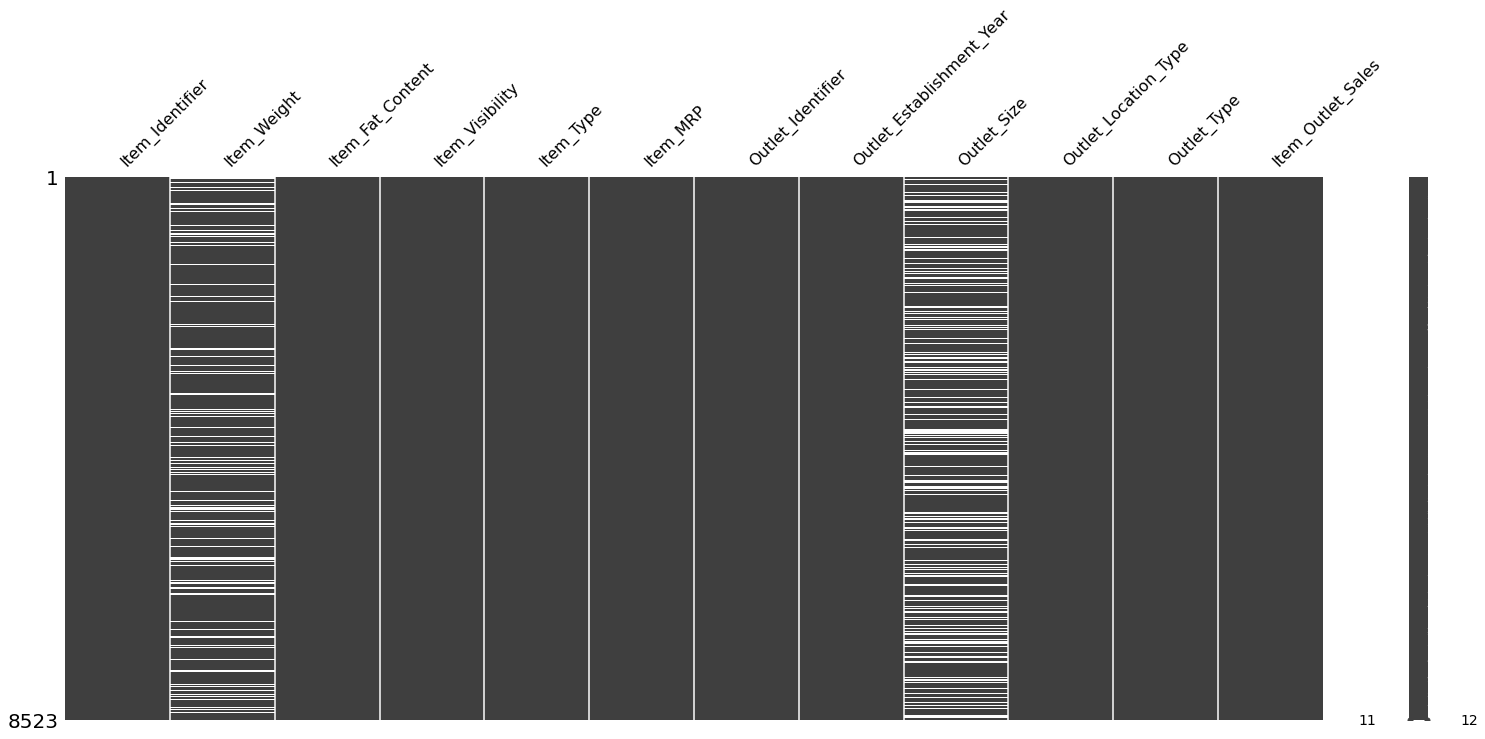

In [11]:
import missingno
missingno.matrix(df)

##Step 5

Justification for Outlet_Size: 

>Filling missing data with a new category called 'Missing'. Loose correlation from Outlet_Size to Item_Outlet_Sales, therefore; I decided to not use imputation via mode. Identifying exceptions to highlight patterns of missing data for analysis.

In [12]:
df['Outlet_Size'].fillna('Missing', inplace=True)

Justification for Item_Weight:
>Respective item identifier reveals equal item weight across its distribution of observations. We can correlate missing values by item identifier by using the grouby function to replace respective null values. 

>Item identifier allows us to make a good judgement call on its item weight based on existing values with the same item identifier.

>Using median, mean, or mode by its item identifier will not have an affect on output, due to equal value for a respective observation

In [13]:
df.groupby('Item_Identifier')['Item_Weight'].describe()

,count,mean,std,min,25%,50%,75%,max
Item_Identifier,,,,,,,,
DRA12,6.0,11.600,0.000000e+00,11.600,11.600,11.600,11.600,11.600
DRA24,5.0,19.350,0.000000e+00,19.350,19.350,19.350,19.350,19.350
DRA59,6.0,8.270,1.945901e-15,8.270,8.270,8.270,8.270,8.270
DRB01,2.0,7.390,0.000000e+00,7.390,7.390,7.390,7.390,7.390
DRB13,5.0,6.115,0.000000e+00,6.115,6.115,6.115,6.115,6.115
...,...,...,...,...,...,...,...,...
NCZ30,6.0,6.590,9.729507e-16,6.590,6.590,6.590,6.590,6.590
NCZ41,5.0,19.850,0.000000e+00,19.850,19.850,19.850,19.850,19.850
NCZ42,5.0,10.500,0.000000e+00,10.500,10.500,10.500,10.500,10.500


> This will replace nulls using the same Item_Identifier with an existing Item_Weight

In [14]:
df['Item_Weight'] = (df.set_index('Item_Identifier').Item_Weight
                  .fillna(df.groupby('Item_Identifier').Item_Weight.median()).values)

>There were 4 observations that were unique, so now will use the median value of Item_Type to replace these nulls.

In [15]:
df['Item_Weight'] = (df.set_index('Item_Type').Item_Weight
                  .fillna(df.groupby('Item_Type').Item_Weight.median()).values)

##Step 6

>Checking for missing values again

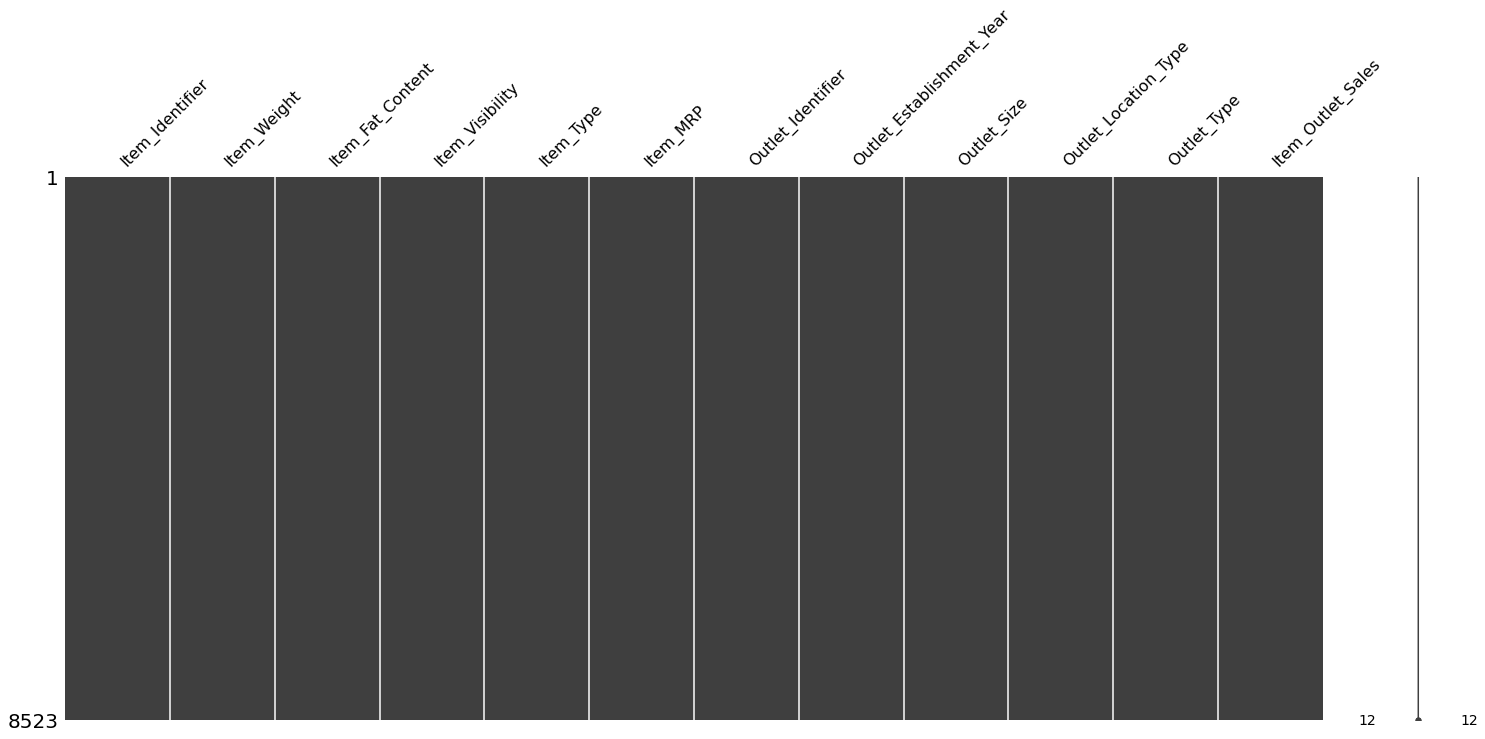

In [16]:
#Confirm that there are no missing values after addressing them.
missingno.matrix(df)

In [17]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

##Step 7

>Check for inconsistent categorical observations

In [18]:
#Notice 'reg' and 'LF', these two categorical items can be replaced with Regular and Low Fat respectively
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')

In [19]:
# Export DataFrame to Excel File
df.to_excel(excel_writer='sales_prediction.xlsx',index=False)

##Step 8

>Summary statistics of each numerical feature (min, max, mean)

In [20]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.875361,0.066132,140.992782,1997.831867,2181.288914
std,4.645031,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026989,93.826500,1987.000000,834.247400
50%,12.650000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#Univariate Exploratory Visualizations and Analysis

#Histogram of Item Outlet Sales

>The observation of this feature and values show a positively skewed distribution (i.e., mean>median>mode). Most of the values for item outlet sales are clustered around the left tail of the distribution while the right tail of the distribution is longer. 

>This positive skewness offers insight to the supermarket chain's sales volume. The skewness indicates that an outlet may have frequent smaller gains and a few larger gains as an enterprise.


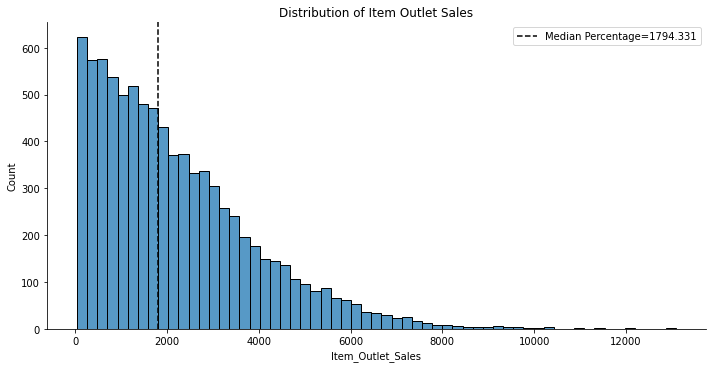

In [21]:
g = sns.displot(data=df, x = 'Item_Outlet_Sales', aspect=2)

g.ax.set(title = 'Distribution of Item Outlet Sales')

median = df['Item_Outlet_Sales'].median()
g.ax.axvline(median, color='k', ls='--', 
            label=f"Median Percentage={median}")
g.ax.legend(loc = 1, bbox_to_anchor = (1,1));

Item Outlet Sales Boxplots Grouped By Size

>This gives us quick insight into our positively skewed distribution. Notice how Medium has more extreme observations than the rest. This suggest that the Medium size stores are outperforming the other store sizes.

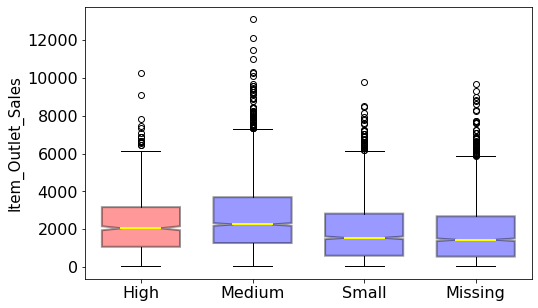

In [22]:
 def foo(): 
    ...:     print('') 
    ...:     x = np.array([[1],[1,2]]) 
    ...:     return x 
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
foo()

High = df.loc[df["Outlet_Size"]=="High", "Item_Outlet_Sales"]
Medium = df.loc[df["Outlet_Size"]=="Medium", "Item_Outlet_Sales"]
Small = df.loc[df["Outlet_Size"]=="Small", "Item_Outlet_Sales"]
Missing = df.loc[df["Outlet_Size"]=="Missing", "Item_Outlet_Sales"]
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8,5))
boxplots = axes.boxplot([High, Medium, Small, Missing],
           notch = True,
           labels=['High', 'Medium', 'Small', 'Missing'],
           widths = .7,
           patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
          );

boxplot1 = boxplots['boxes'][0]
boxplot1.set_facecolor('red')
plt.ylabel('Item_Outlet_Sales', fontsize = 15);
plt.xticks(fontsize = 16);
plt.yticks(fontsize = 16);

##Heat Map

>Based on this Heat Map, at a glance, we can see that there is weak correlation across the features.

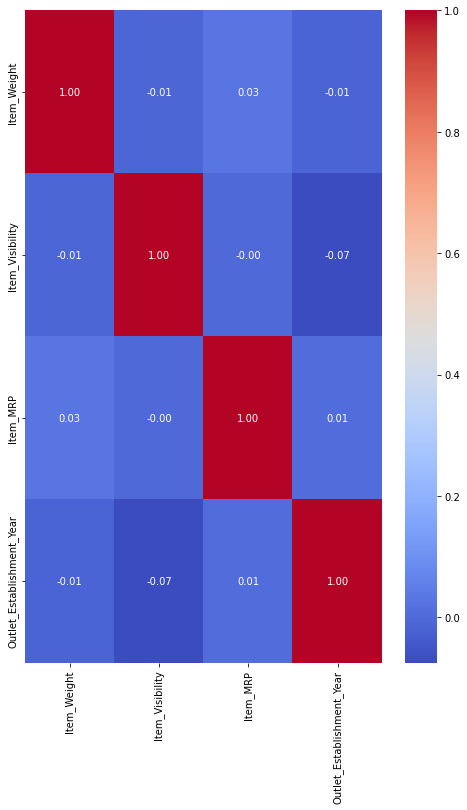

In [23]:
corr = df.corr()
corr = df.drop(columns='Item_Outlet_Sales').corr()
corr

plt.figure(figsize=(8,12))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt ='.2f')

##Part 4

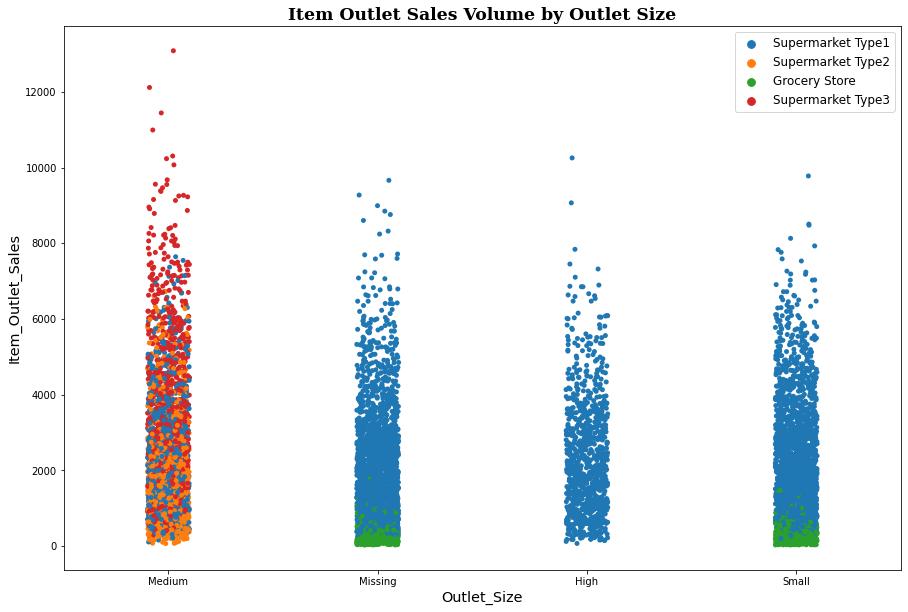

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.stripplot(data = df, x = 'Outlet_Size', y = 'Item_Outlet_Sales', hue = 'Outlet_Type')

ax.set_title('Item Outlet Sales Volume by Outlet Size', 
             fontfamily='serif',
             fontsize='xx-large',
             fontweight='semibold');

ax.set_xlabel(ax.xaxis.get_label().get_text(),
    fontsize='x-large')

ax.set_ylabel(ax.yaxis.get_label().get_text(),
    fontsize='x-large')


ax.legend(bbox_to_anchor=[1,1], fontsize = 'large')

>The chart above provides a quick dispersion of our outlet sizes. It not only gives us a distribution of outlet sales, but also shows us what type of outlet make up these sizes.

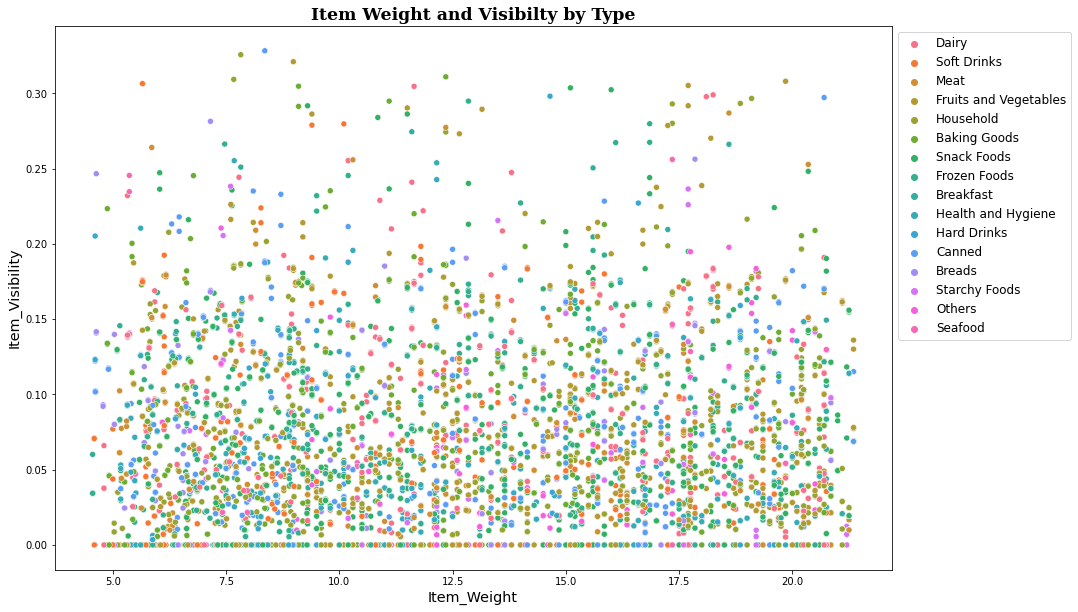

In [25]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.scatterplot(data = df, x = 'Item_Weight', y = 'Item_Visibility', hue = 'Item_Type')
ax.legend(bbox_to_anchor=[1,1])

ax.set_title('Item Weight and Visibilty by Type', 
             fontfamily='serif',
             fontsize='xx-large',
             fontweight='semibold');

ax.set_xlabel(ax.xaxis.get_label().get_text(),
    fontsize='x-large')

ax.set_ylabel(ax.yaxis.get_label().get_text(),
    fontsize='x-large')


ax.legend(bbox_to_anchor=[1,1], fontsize = 'large')

>Scatter plot chart displays that there are no clear negative or positive correlations for an item's weight and its visibility by type. 

##Machine Learning Preprocessing Phase


Identifying the features (X) and target (y): Assigning the Item_Outlet_Sales column as the target and the rest of the relevant variables as the features matrix, except Item_Identifier and Outlet_Identifier.

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [27]:
#readdress missing values, we will use pipelines to impute missing values in weight
df1.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [28]:
#replacing Outlet_Size nulls with 'Missing' to analyze the missing datapoints vice imputation such as most frequent
df1['Outlet_Size'].fillna('Missing', inplace=True)

In [29]:
#check for duplicates
df1.duplicated().sum()

0

In [30]:
#identifying this as an ordinal object
df1['Outlet_Size'].value_counts()

Medium     2793
Missing    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64

In [31]:
#preparing it prior to spit, will not cause data leakage
df1['Outlet_Size'].replace({'Small':1, 'Medium':2, 'High':3, 'Missing':0}, inplace=True)

In [32]:
#Outlet_Type may be ordinal, but going to keep this as nominal along with the other objects
df1['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

Perform a train test split 

In [33]:
#splitting, dropping Item_Identifier and Outlet_Identifier, too many unique IDs will not be relevant for the model. 
#Defining X and y
target = 'Item_Outlet_Sales'
X = df1.drop(columns = [target, 'Item_Identifier', 'Outlet_Identifier'])
y = df1[target]

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape

(6392, 9)

In [34]:
#identified standardization issues with the Item_Fat_Content values with train, we will clean the train and check test separately to prevent data peeking
X_train['Item_Fat_Content'].value_counts()

Low Fat    3783
Regular    2176
LF          260
reg          87
low fat      86
Name: Item_Fat_Content, dtype: int64

In [35]:
#defining a dictionary training variable to replace
item_fat_content_train = {'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'}

#applying the dictionary to the column in the train data
X_train['Item_Fat_Content'] = X_train['Item_Fat_Content'].replace(item_fat_content_train)

#viewing the train dataframe using value_counts to make sure it worked
X_train['Item_Fat_Content'].value_counts()

Low Fat    4129
Regular    2263
Name: Item_Fat_Content, dtype: int64

In [36]:
#selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [37]:
#numeric imputer only
mean_imputer = SimpleImputer(strategy='mean')

#scaler
scaler = StandardScaler()

#one-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [38]:
#numeric pipeline, using mean_imputer
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [39]:
#not imputing any categorical values because I addressed them prior without using imputation via mean, mode, or median
categorical_pipe = make_pipeline(ohe)
categorical_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

Create a preprocessing object to prepare the dataset for Machine Learning

In [40]:
#tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
#Column Transformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f45a8a49a90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f45a8a499d0>)])

In [41]:
#fit on train only
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f45a8a49a90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f45a8a499d0>)])

In [42]:
#transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [43]:
#check for missing values, data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 30)




array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

>We are now ready for the deployment phase of Machine Learning!